In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv("../data/cleanedData.csv")

In [3]:
# Separate target(label) from predictor columns
y = df.label

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['fullContent'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

sparse_features = csr_matrix(df[["urls", "totalLength", "generalConsumer", "govDomain", "eduDomain", "orgDomain", "netDomain", "otherDomain", "html", "punctuationCount"]].values)

X = hstack([sparse_features, tfidf_matrix])

In [5]:
# Split full dataset into training set(80%) and testing set(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
y_pred = model.predict(X_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy: ", accuracy)

Model accuracy:  0.9179272973583201


In [9]:
def printCM(predictLabels, trueLabels):
    class_report = classification_report(trueLabels, predictLabels)
    print(class_report)

    cm = confusion_matrix(trueLabels, predictLabels)

    # Define class labels for the confusion matrix (for binary classification)
    class_labels = ['Phishing', 'Non-Phishing']  # Adjust according to your classes

    # Create the heatmap without annotations (annot=False)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

    # Set axis labels
    ax.set_xlabel('True', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)

    # Set the class labels on the axes
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    # Set title
    plt.title('Confusion Matrix')

    # Manually add True Positive, False Positive, True Negative, and False Negative annotations
    # You must use the exact cell positions for each term in the 2x2 confusion matrix
    ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    return plt.show()

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4210
           1       0.91      0.94      0.92      4648

    accuracy                           0.92      8858
   macro avg       0.92      0.92      0.92      8858
weighted avg       0.92      0.92      0.92      8858



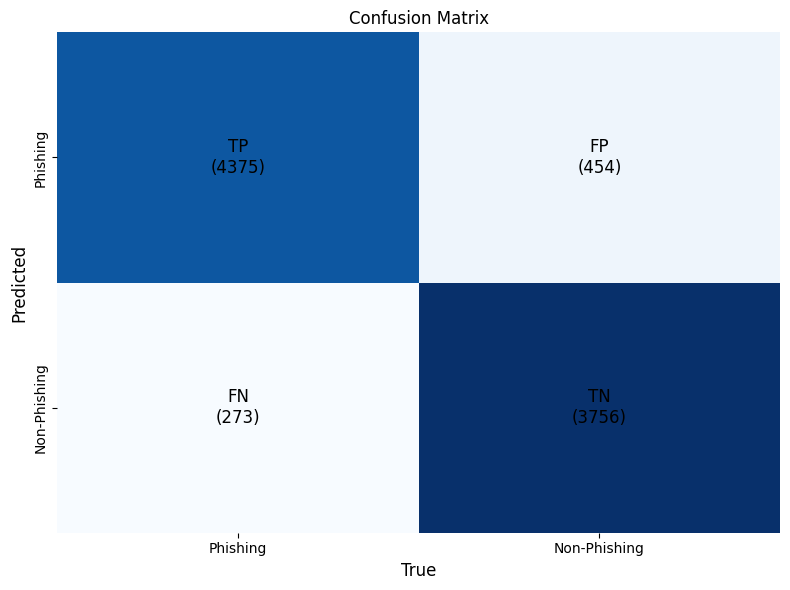

In [10]:
printCM(y_pred, y_test)

In [11]:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'tol': [1e-4, 1e-3, 1e-2],
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


In [12]:
model = LogisticRegression(**grid_search.best_params_)
model.fit(X_train, y_train)


LogisticRegression(C=0.1, solver='liblinear')

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy: ", accuracy)

Model accuracy:  0.9655678482727478


In [14]:
def printCM(predictLabels, trueLabels):
    class_report = classification_report(trueLabels, predictLabels)
    print(class_report)

    cm = confusion_matrix(trueLabels, predictLabels)

    # Define class labels for the confusion matrix (for binary classification)
    class_labels = ['Phishing', 'Non-Phishing']  # Adjust according to your classes

    # Create the heatmap without annotations (annot=False)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

    # Set axis labels
    ax.set_xlabel('True', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)

    # Set the class labels on the axes
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    # Set title
    plt.title('Confusion Matrix')

    # Manually add True Positive, False Positive, True Negative, and False Negative annotations
    # You must use the exact cell positions for each term in the 2x2 confusion matrix
    ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    return plt.show()

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4210
           1       0.97      0.97      0.97      4648

    accuracy                           0.97      8858
   macro avg       0.97      0.97      0.97      8858
weighted avg       0.97      0.97      0.97      8858



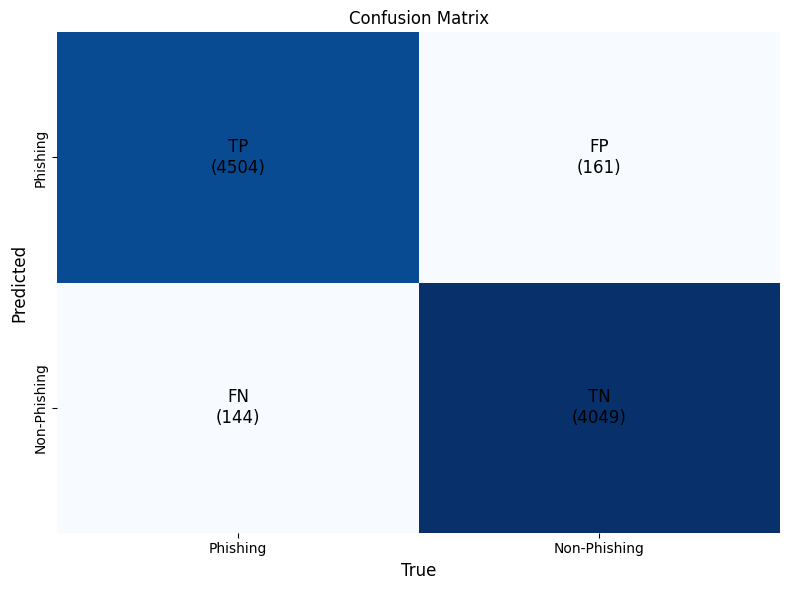

In [15]:
printCM(y_pred, y_test)

In [16]:
with open('../model/LogisticRegression_KayCheng.pkl', 'wb') as file: pickle.dump(model, file)